<a href="https://colab.research.google.com/github/yuxuanyao/FMNIST/blob/master/FMNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DC GAN 
Notes: 

#GAN

- Used to describe the world
- You can feed it conditionals to describe different stuff

##BigGAN
- Generate a lot of realistic images

##Architecture 
- Critic (high dimension to low dimension)
- Artist (low dimension to high dimension)

Real Sample -> Real -> 
                                      -> Critic -> real or fake?             
Noise -> Artist -> fake samples -> real 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib

# enable eager execution
tf.enable_eager_execution()

In [2]:
# check that TF can detect GPU
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7560284398260054796, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5919987598351696027
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6565298725157516251
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11173969920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3294768935504644098
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# 1 Fashion MNIST Dataset

Load train/test datasets from API

In [0]:
# download the fashion mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
# examine dataset format
print("train images: type: {}; shape: {}".format(type(train_images), train_images.shape))
print("test images: type:  {}; shape: {}".format(type(test_images), test_images.shape))

# examine class frequency

print("train labels: {}".format([(a,b) for a, b in zip(np.unique(train_labels), np.bincount(train_labels))]))
print("test labels:  {}".format([(a,b) for a, b in zip(np.unique(test_labels), np.bincount(test_labels))]))

train images: type: <class 'numpy.ndarray'>; shape: (60000, 28, 28)
test images: type:  <class 'numpy.ndarray'>; shape: (10000, 28, 28)
train labels: [(0, 6000), (1, 6000), (2, 6000), (3, 6000), (4, 6000), (5, 6000), (6, 6000), (7, 6000), (8, 6000), (9, 6000)]
test labels:  [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


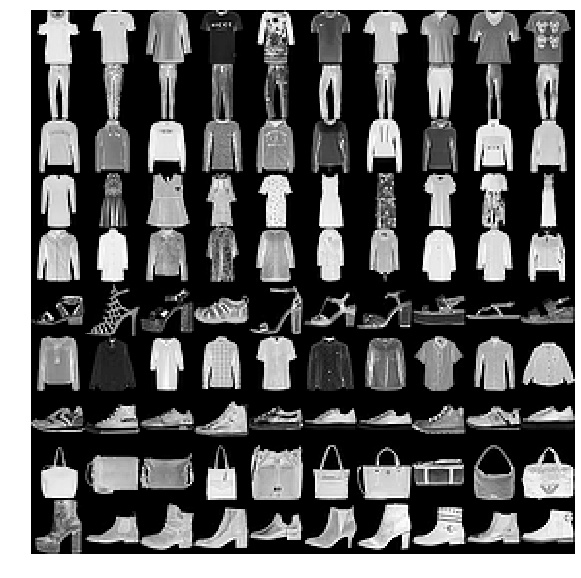

In [5]:
# visualize some of the images by randomly sampling a few images from each class
img_samples = []
for cls in list(np.unique(train_labels)):
    indices = np.where(train_labels==cls)[0]    
    samples = np.random.choice(a=indices, size=10, replace=False)
    img_samples.append(train_images[samples,:,:])
img_samples = tf.constant(np.concatenate(img_samples))
img_samples = tf.expand_dims(img_samples, 3)

# generate a 10 x 10 image grid
img_grid = tf.contrib.gan.eval.image_grid(
                input_tensor=img_samples,
                grid_shape=(10,10),
                image_shape=(28,28),
                num_channels=1
            )

# plot the image grid
plt.figure(figsize=(10,10))
plt.imshow(img_grid[0,:,:,0], cmap='gray')
plt.axis('off')
plt.show()

# 2 GAN Models

In [0]:
# Import keras modules that we will be using to construct our models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, ReLU, Activation, Flatten, Conv2D, LeakyReLU, 
    Conv2DTranspose, Input, Reshape, BatchNormalization
)

In [7]:
# create an image batch for testing model functionalities
images = train_images[:64,:,:]/128. - 1.
images = tf.constant(images, dtype=tf.float32)
images = tf.expand_dims(images, 3)
images.shape

TensorShape([Dimension(64), Dimension(28), Dimension(28), Dimension(1)])

In [0]:
# input image shape information
H, W, C =28, 28, 1
LATENT_DIM=16

# alpha param for leaky ReLu
ALPHA = 0.2

### Discriminator

In [0]:
def build_discriminator():
    return Sequential([
        # reshape input layer
        Reshape((H, W, C), input_shape=(H, W)),
        # 1st conv2D layer
        Conv2D(filters=32, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        # 2nd conv2D layer
        Conv2D(filters=64, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        # 3rd conv2D layer
        Conv2D(filters=128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(ALPHA),
        # Flatten conv2D output
        Flatten(),
        # Output layer
        Dense(units=1),
        Activation('tanh')
    ])
      
      
def compute_d_loss(d_logits_real, d_logits_fake):
    """
    loss computation for the discriminator net
    """
    # Hinge loss
    real_loss = tf.reduce_mean(tf.nn.relu(1. - d_logits_real))
    fake_loss = tf.reduce_mean(tf.nn.relu(1. + d_logits_fake))

    return real_loss + fake_loss

In [10]:
# unit test
d_net = build_discriminator()
print(d_net.summary())
test = d_net(images)
print('\ndiscriminator loss: ', compute_d_loss(test, test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)         0         
__________

### Generator

In [0]:
def build_generator():
    return Sequential([
        # fully connected layer on latent vector
        Dense(units=(H/4)*(W/4)*64, use_bias=False, input_shape=[LATENT_DIM]),
        BatchNormalization(),
        LeakyReLU(ALPHA),
        # reshape 1-D tensor into 3-D tensor
        Reshape(((H/4), (W/4), 64)),
        # 1st deconv operation
        Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(ALPHA),
        # 2nd deconv operation
        Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(ALPHA),
        # 3rd deconv operation
        Conv2DTranspose(filters=C, kernel_size=5, strides=2, padding='same', use_bias=False),
        # output operation
        Activation('tanh'),
    ])

      
def compute_g_loss(d_logits_fake):
    return - tf.reduce_mean(d_logits_fake)

In [12]:
# unit test
g_net = build_generator()
print(g_net.summary())
z_test = tf.random_normal(shape=(64, LATENT_DIM), dtype='float32')
test = g_net(z_test)
test_logit = d_net.call(test)
print('\ndiscriminator loss on generated images: ', compute_g_loss(test_logit))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              50176     
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          102400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

# 3 Model Training

### Setup

In [0]:
# training configuration information
SAMPLE_PER_N_STEPS=200

# training batch size & epoch
BUFFER_SIZE=1000
EPOCHS = 10
BATCH_SIZE = 128

### Optimizers

In [0]:
# learning rates
G_LR = 0.0001
D_LR = 0.0004

# beta params for the Adam optimizer
BETA1 = 0.0
BETA2 = 0.999

# generator optimizer
g_optimizer = tf.train.AdamOptimizer(learning_rate=G_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

# discriminator optimizer
d_optimizer = tf.train.AdamOptimizer(learning_rate=D_LR, 
                                     beta1=BETA1, 
                                     beta2=BETA2)

### Data Pipeline

In [0]:
# combine the train/test datasets because we won't be needing the test dataset
dataset = np.concatenate((train_images, test_images))

# convert dataset to 4-D tensor object format (batch, height, width, channel)
dataset = tf.constant(dataset, dtype=tf.float32)
dataset = tf.expand_dims(dataset, 3)

# create a tf.dataset object that will act as our input pipeline to feed data
# to our models during training
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# we will pre-program how the tf.dataset object will be feeding in data batches
dataset = dataset.map(lambda x: (x / 128.) - 1., num_parallel_calls=4)\
                 .shuffle(BUFFER_SIZE)\
                 .repeat(EPOCHS)\
                 .batch(BATCH_SIZE)

In [16]:
dataset

<BatchDataset shapes: (?, 28, 28, 1), types: tf.float32>

### Training

training step 100: discriminator loss 0.43561631441116333; generator loss 0.9276925921440125
training step 200: discriminator loss 1.2722588777542114; generator loss -0.2715941369533539


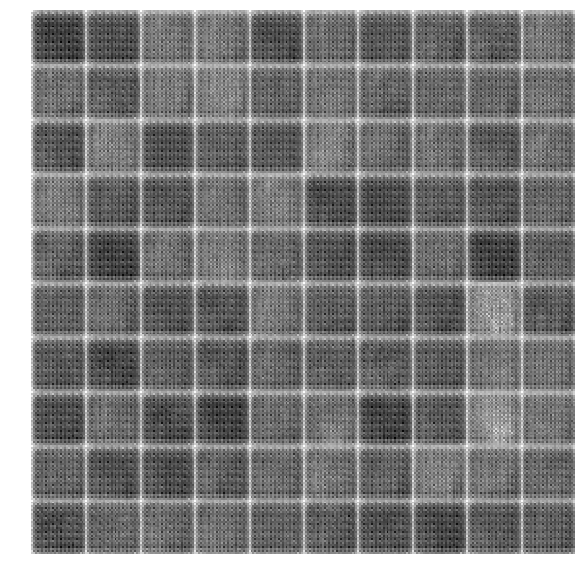

training step 300: discriminator loss 0.8679838180541992; generator loss 0.1466679722070694
training step 400: discriminator loss 0.9316146373748779; generator loss 0.9435753226280212


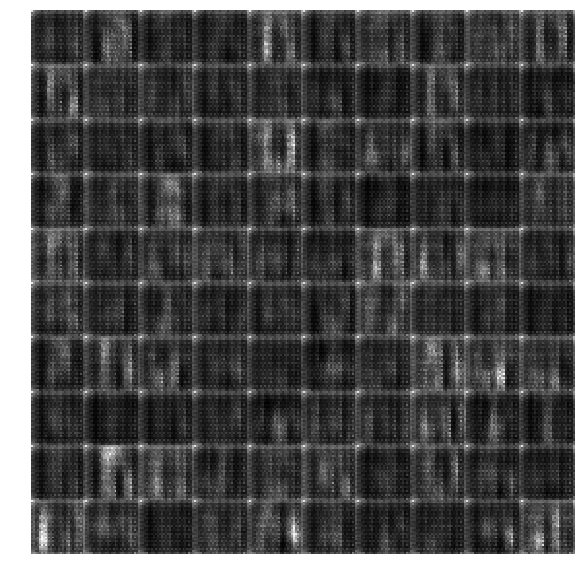

training step 500: discriminator loss 1.1682193279266357; generator loss -0.15910813212394714
training step 600: discriminator loss 0.4138314425945282; generator loss 0.7255660891532898


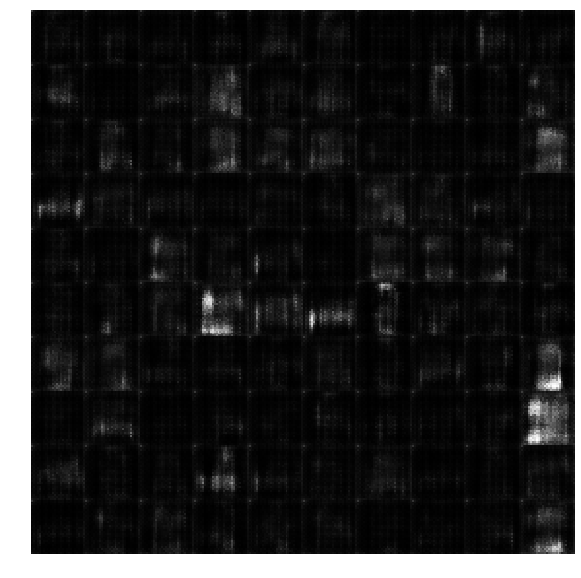

training step 700: discriminator loss 0.9328421950340271; generator loss 0.961961567401886
training step 800: discriminator loss 1.4415160417556763; generator loss 0.9673606157302856


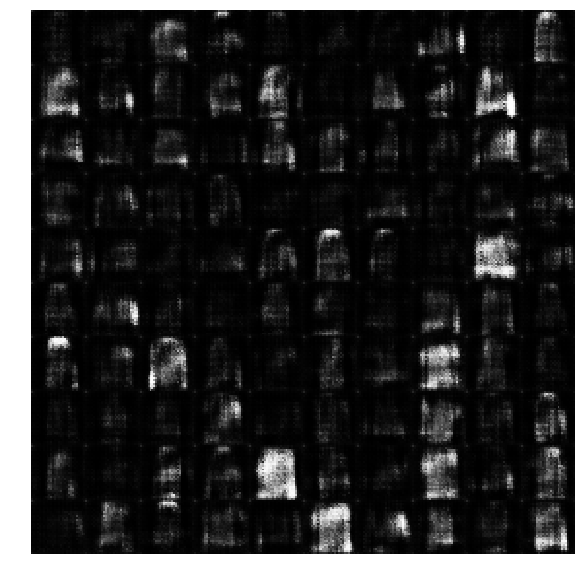

training step 900: discriminator loss 1.336089849472046; generator loss 0.9099306464195251
training step 1000: discriminator loss 0.9723785519599915; generator loss 0.7881292700767517


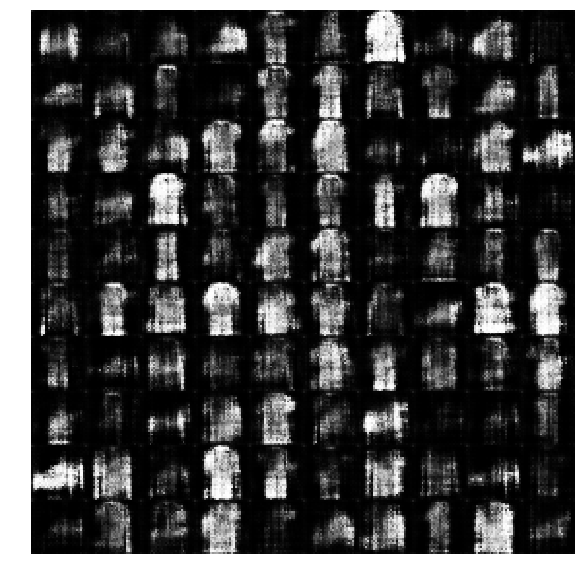

training step 1100: discriminator loss 1.2345384359359741; generator loss 0.8860058188438416
training step 1200: discriminator loss 1.1441564559936523; generator loss 0.8971884250640869


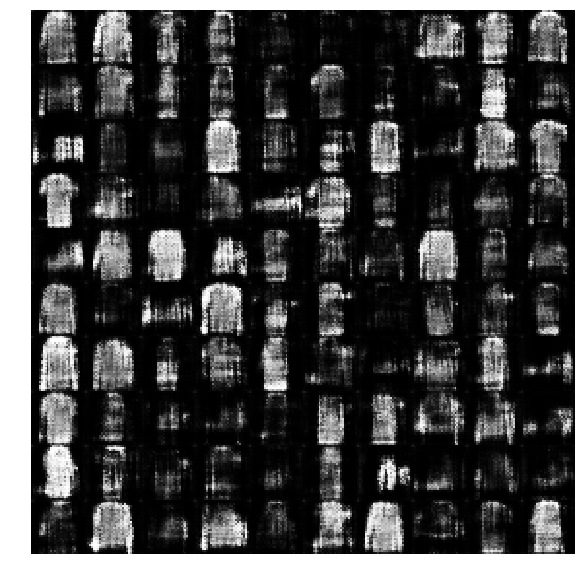

training step 1300: discriminator loss 1.1103020906448364; generator loss 0.09329884499311447
training step 1400: discriminator loss 1.10127854347229; generator loss 0.8536552786827087


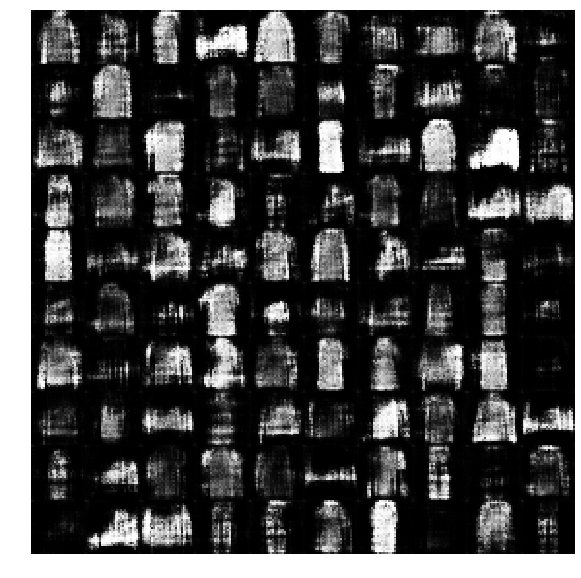

training step 1500: discriminator loss 0.9309475421905518; generator loss 0.6382908225059509
training step 1600: discriminator loss 1.2116062641143799; generator loss 0.8672559857368469


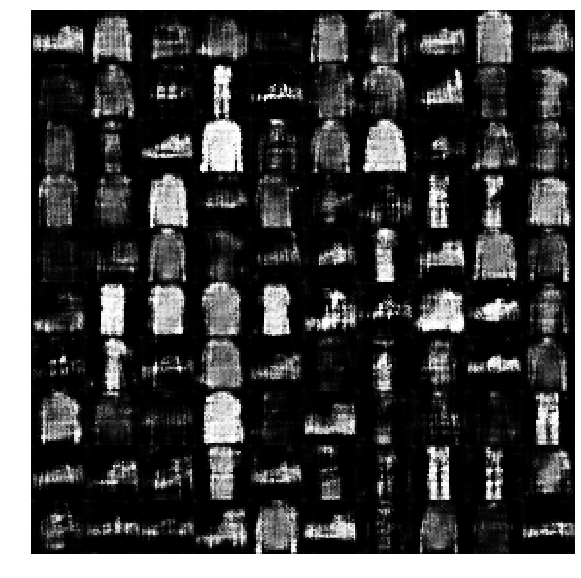

training step 1700: discriminator loss 1.4092828035354614; generator loss -0.27980953454971313
training step 1800: discriminator loss 0.9770245552062988; generator loss 0.38851630687713623


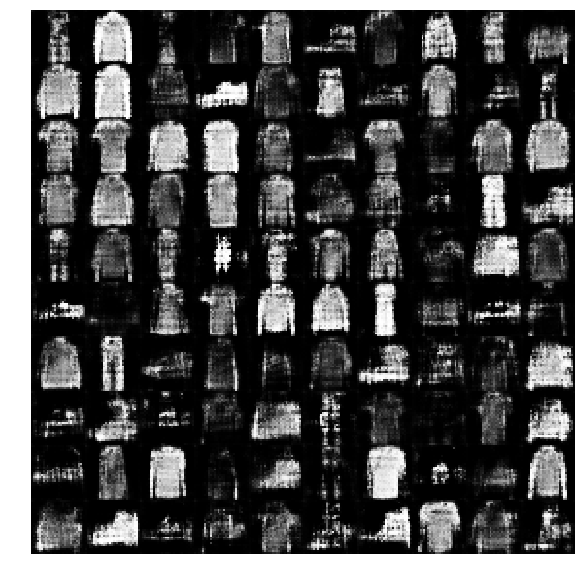

training step 1900: discriminator loss 1.2056896686553955; generator loss 0.056349486112594604
training step 2000: discriminator loss 1.175011396408081; generator loss 0.6621600389480591


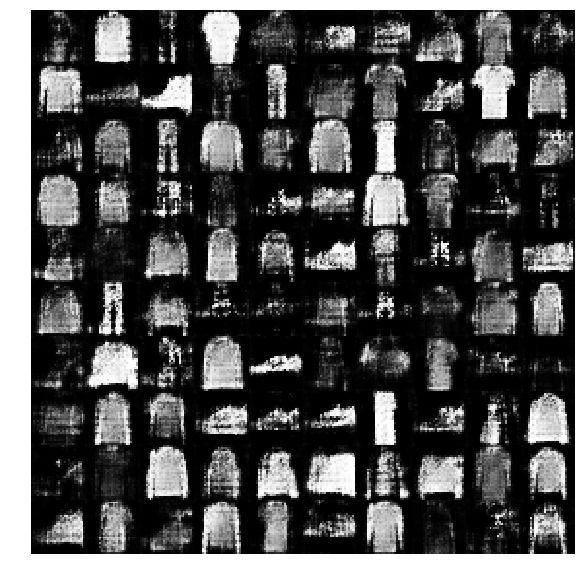

training step 2100: discriminator loss 1.1067912578582764; generator loss 0.17430955171585083
training step 2200: discriminator loss 0.9835227727890015; generator loss 0.815906286239624


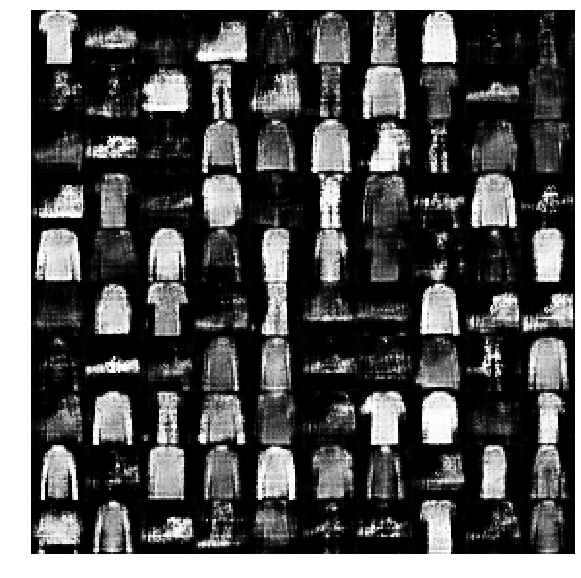

training step 2300: discriminator loss 1.193042278289795; generator loss 0.3623208999633789
training step 2400: discriminator loss 1.2985560894012451; generator loss 0.8786242008209229


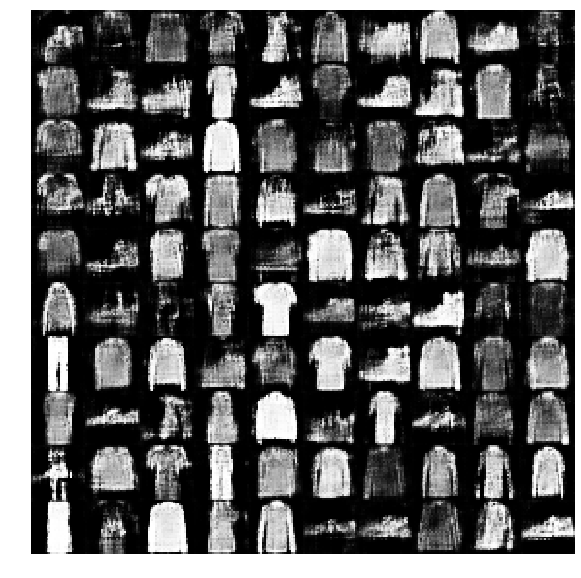

training step 2500: discriminator loss 1.098332166671753; generator loss 0.40610557794570923
training step 2600: discriminator loss 1.4981353282928467; generator loss 0.9648488759994507


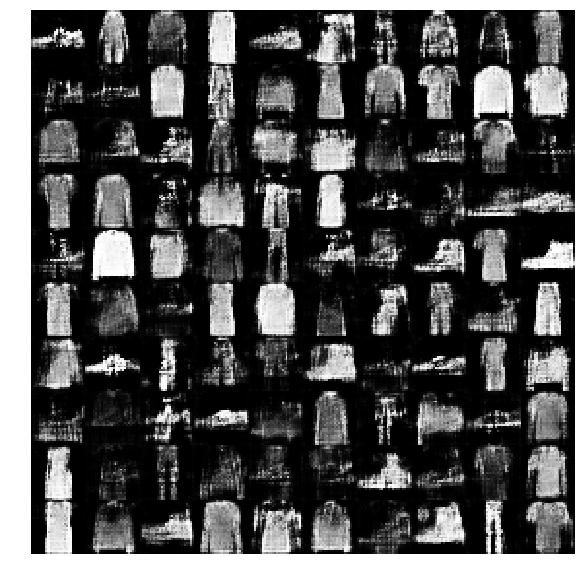

training step 2700: discriminator loss 1.136330485343933; generator loss 0.8381596803665161
training step 2800: discriminator loss 0.9420888423919678; generator loss 0.6938877105712891


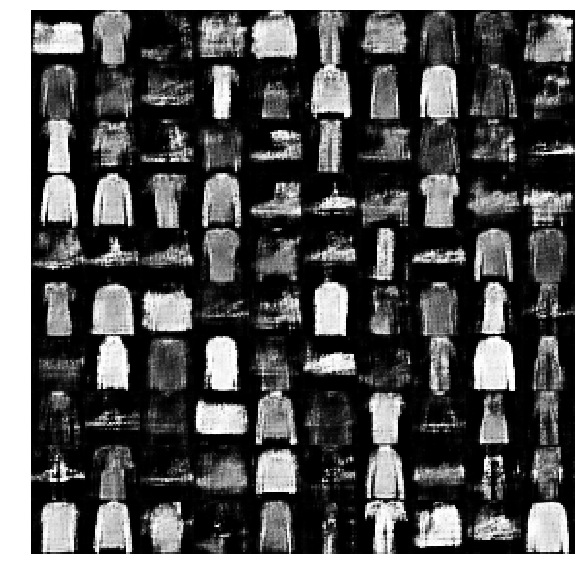

training step 2900: discriminator loss 1.2837289571762085; generator loss -0.08443969488143921
training step 3000: discriminator loss 1.3720608949661255; generator loss -0.22615276277065277


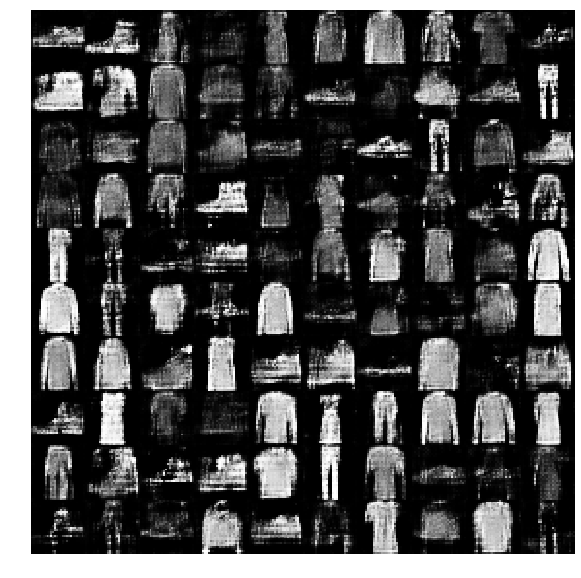

training step 3100: discriminator loss 1.100988507270813; generator loss 0.20153968036174774
training step 3200: discriminator loss 1.0123692750930786; generator loss 0.3648873269557953


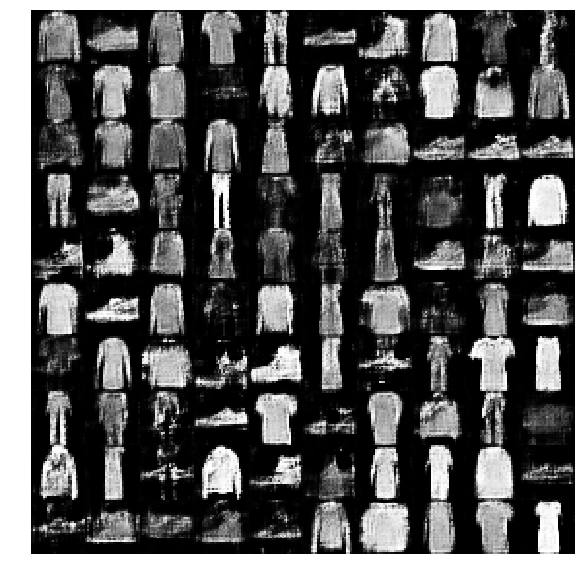

training step 3300: discriminator loss 1.1902896165847778; generator loss 0.8955315351486206
training step 3400: discriminator loss 1.1715433597564697; generator loss 0.8684032559394836


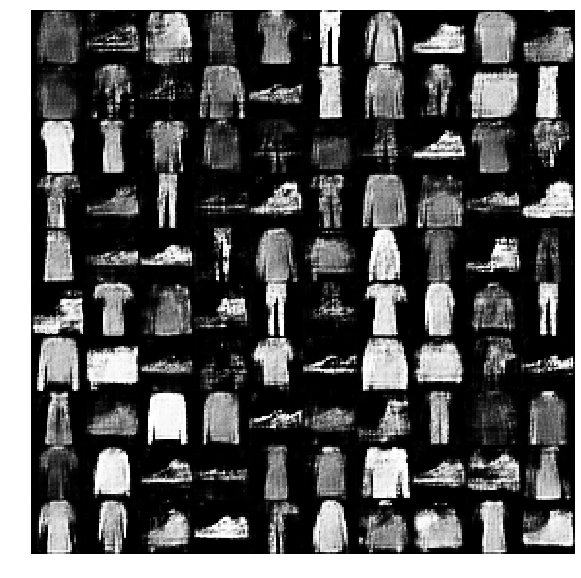

training step 3500: discriminator loss 1.1103781461715698; generator loss 0.12504339218139648
training step 3600: discriminator loss 1.165960669517517; generator loss 0.10152839869260788


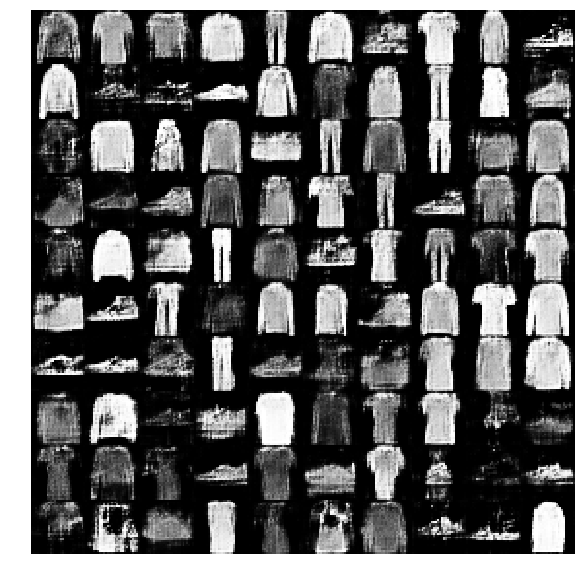

training step 3700: discriminator loss 1.0218137502670288; generator loss 0.7467403411865234
training step 3800: discriminator loss 1.0975967645645142; generator loss 0.4637562334537506


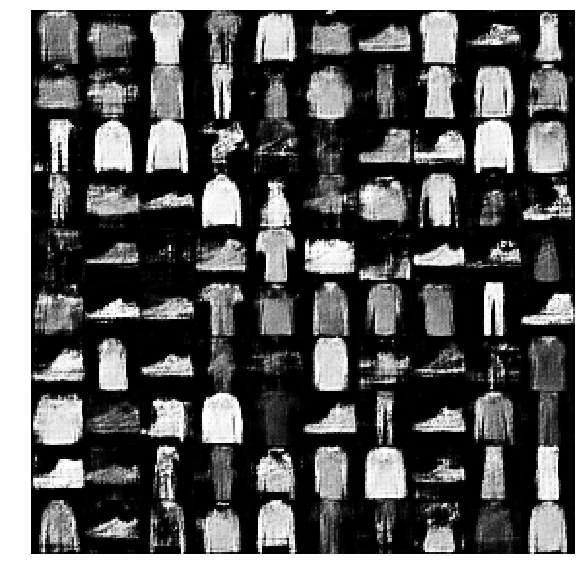

training step 3900: discriminator loss 1.0089999437332153; generator loss 0.7617449164390564
training step 4000: discriminator loss 1.2289972305297852; generator loss 0.5186347961425781


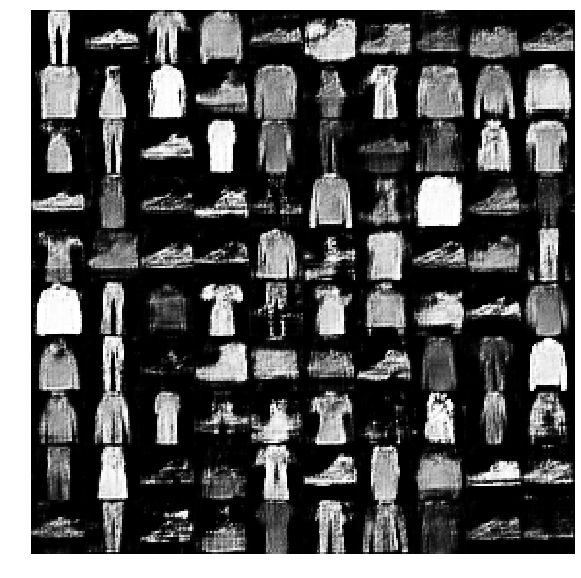

training step 4100: discriminator loss 1.1768792867660522; generator loss 0.8222349882125854
training step 4200: discriminator loss 1.195702075958252; generator loss 0.05573771148920059


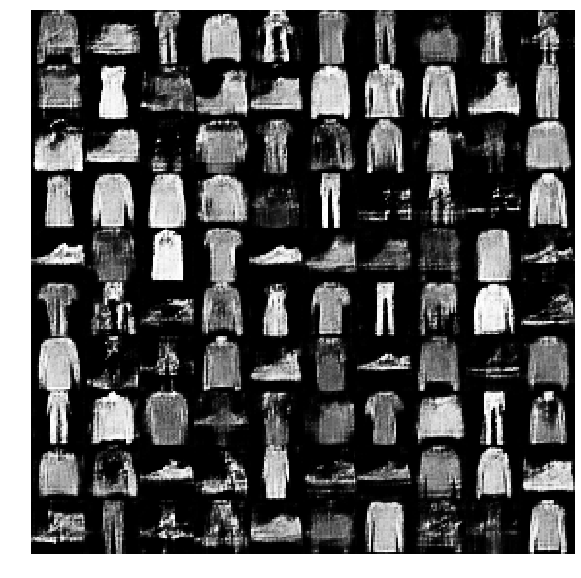

training step 4300: discriminator loss 1.5894302129745483; generator loss -0.46409767866134644
training step 4400: discriminator loss 1.0528051853179932; generator loss 0.7837410569190979


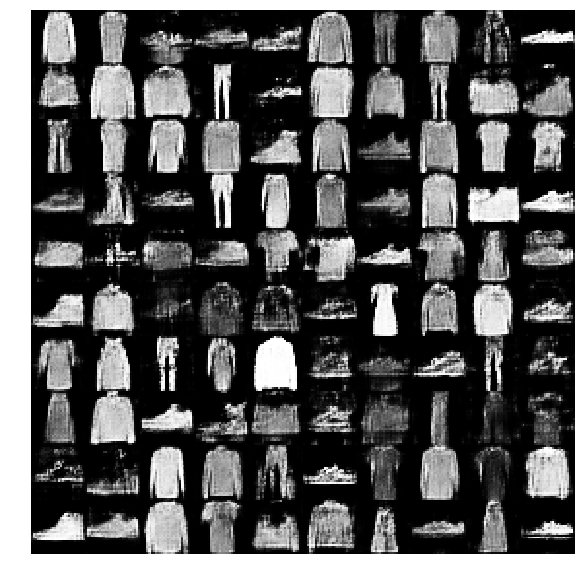

training step 4500: discriminator loss 1.2620024681091309; generator loss 0.22866204380989075
training step 4600: discriminator loss 1.0957456827163696; generator loss 0.8917538523674011


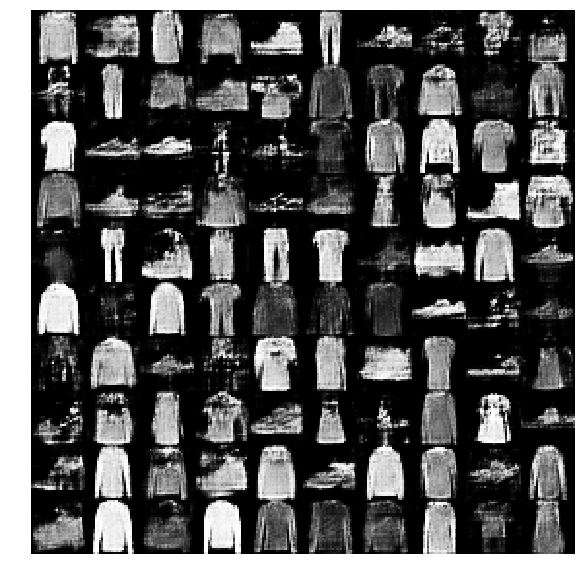

training step 4700: discriminator loss 0.9958306550979614; generator loss 0.33471643924713135
training step 4800: discriminator loss 1.2048213481903076; generator loss 0.23601001501083374


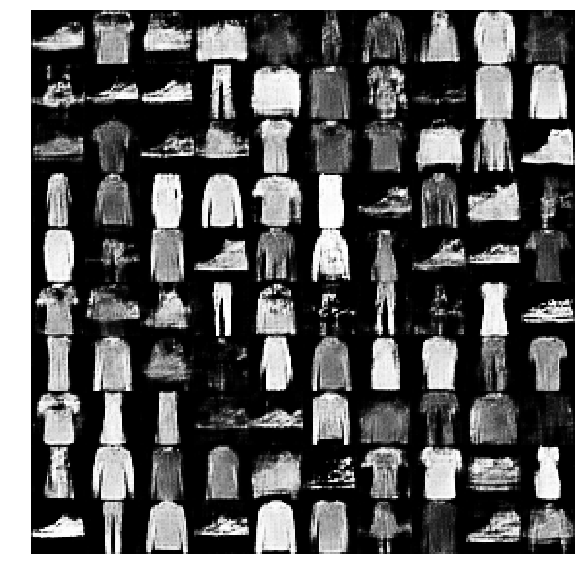

training step 4900: discriminator loss 1.104750156402588; generator loss 0.8964128494262695
training step 5000: discriminator loss 0.9470267295837402; generator loss 0.5824188590049744


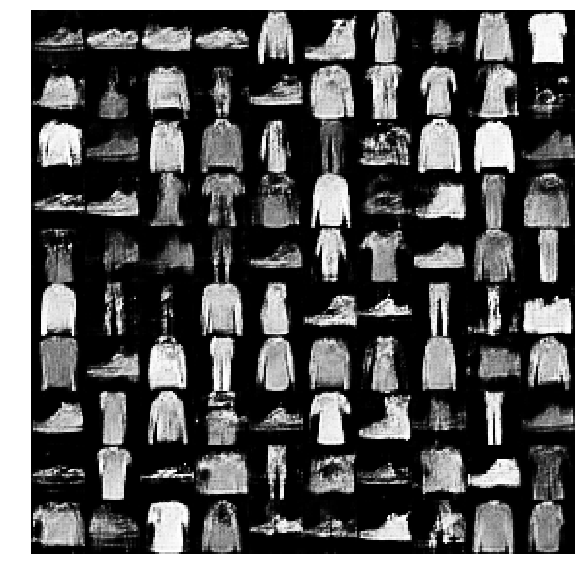

training step 5100: discriminator loss 1.2755464315414429; generator loss 0.9354919791221619
training step 5200: discriminator loss 1.0609123706817627; generator loss 0.5560593008995056


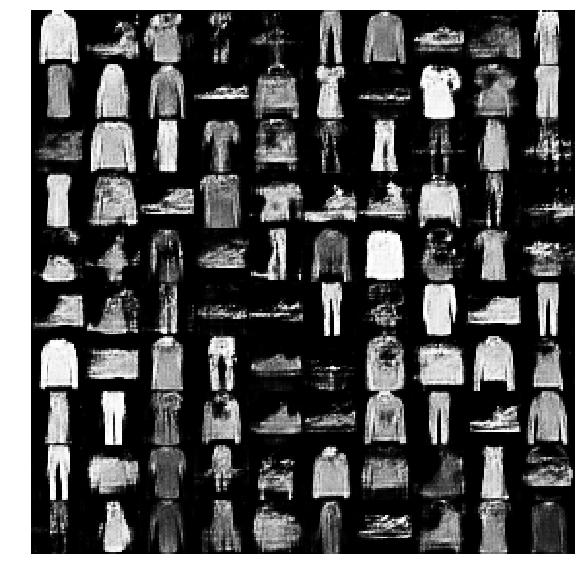

training step 5300: discriminator loss 1.014171838760376; generator loss 0.3420611321926117
training step 5400: discriminator loss 1.266418695449829; generator loss -0.0692773163318634


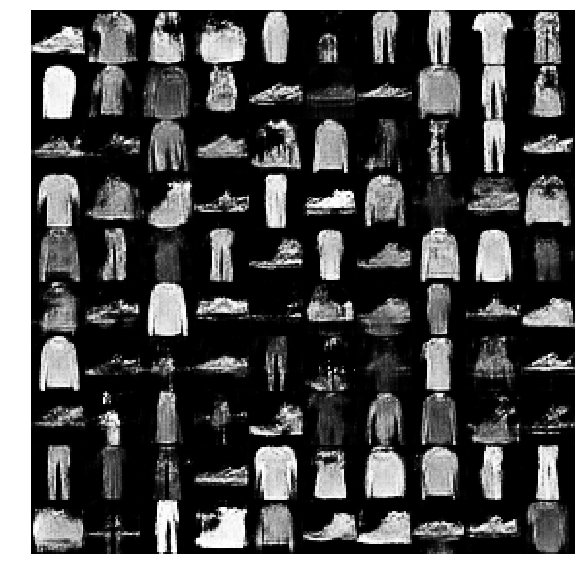

training step 5500: discriminator loss 0.9349679946899414; generator loss 0.35996878147125244
training step 5600: discriminator loss 1.0592941045761108; generator loss 0.41719383001327515


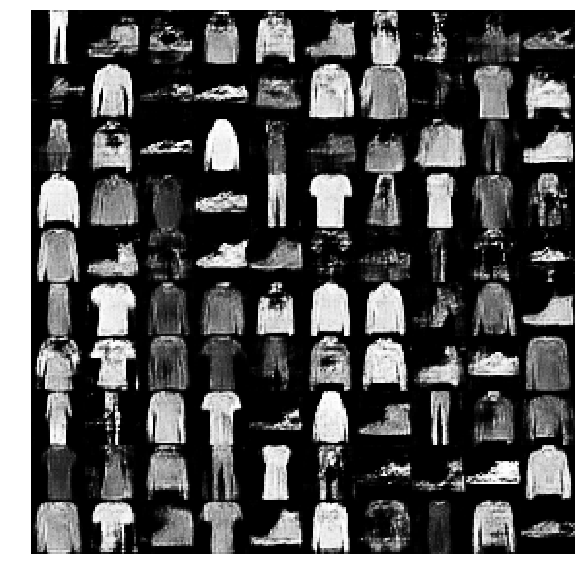

training step 5700: discriminator loss 1.0857429504394531; generator loss 0.3661506772041321
training step 5800: discriminator loss 1.1184589862823486; generator loss 0.8647502660751343


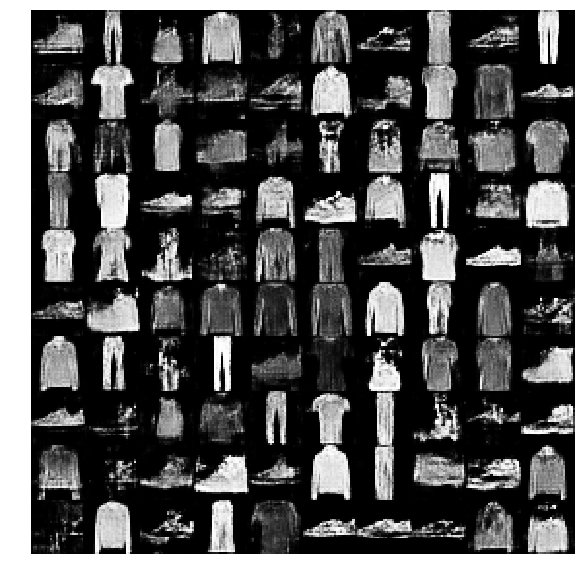

training step 5900: discriminator loss 1.1694672107696533; generator loss 0.517696738243103
training step 6000: discriminator loss 1.3656213283538818; generator loss 0.9613550305366516


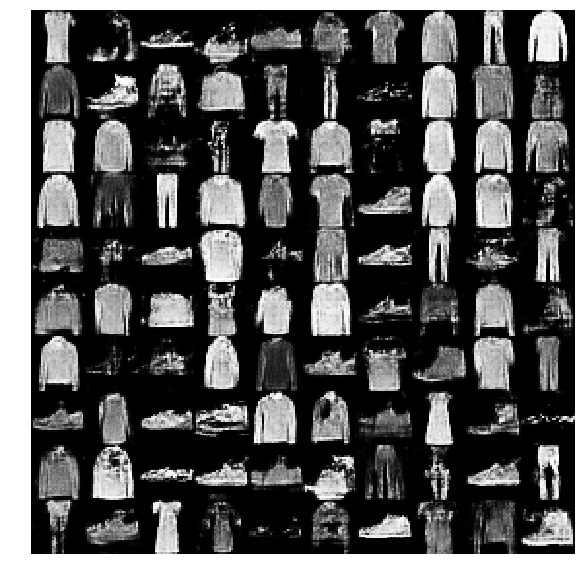

training step 6100: discriminator loss 1.3370004892349243; generator loss 0.956001877784729
training step 6200: discriminator loss 1.1307907104492188; generator loss 0.3777240216732025


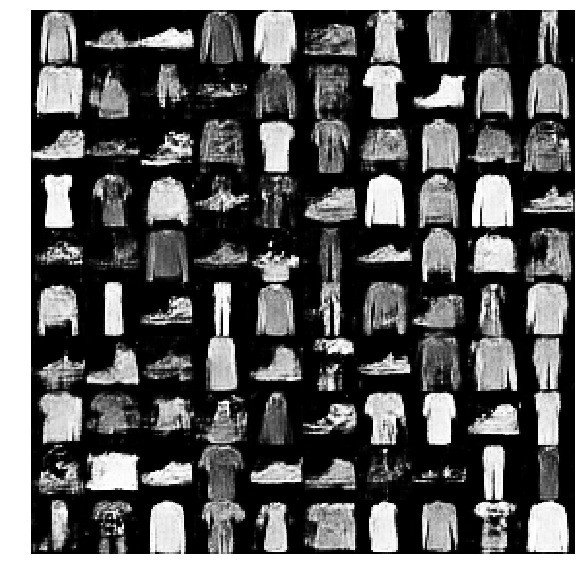

training step 6300: discriminator loss 1.179055094718933; generator loss 0.7938253879547119
training step 6400: discriminator loss 1.41365385055542; generator loss -0.05244974419474602


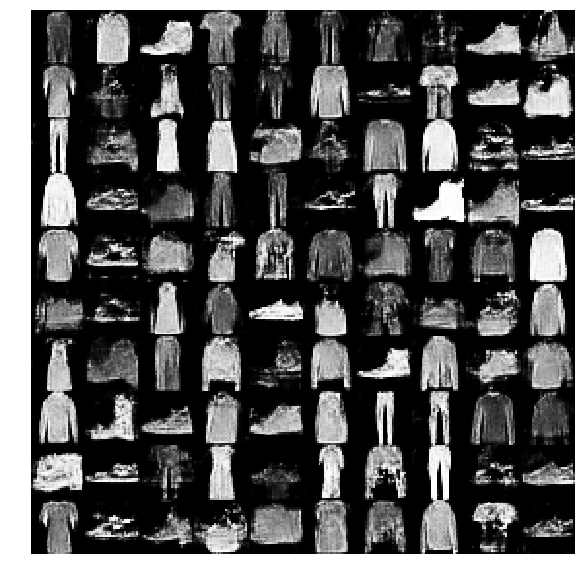

training step 6500: discriminator loss 1.0331956148147583; generator loss 0.5005211234092712
training step 6600: discriminator loss 1.0362136363983154; generator loss 0.6400017142295837


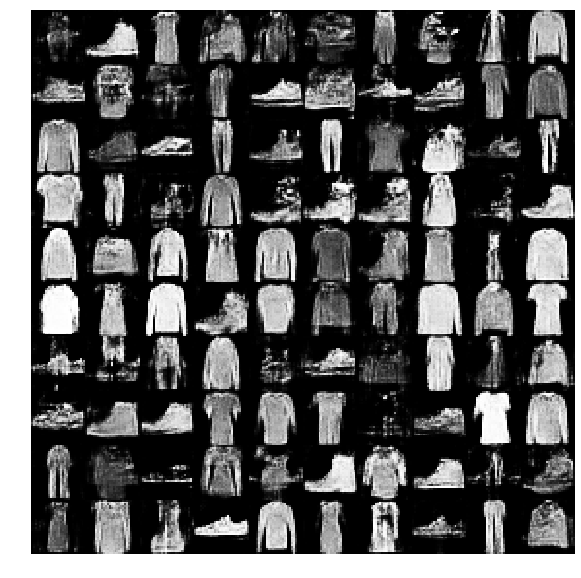

training step 6700: discriminator loss 0.9481230974197388; generator loss 0.7813844680786133
training step 6800: discriminator loss 1.2222480773925781; generator loss 0.8873578906059265


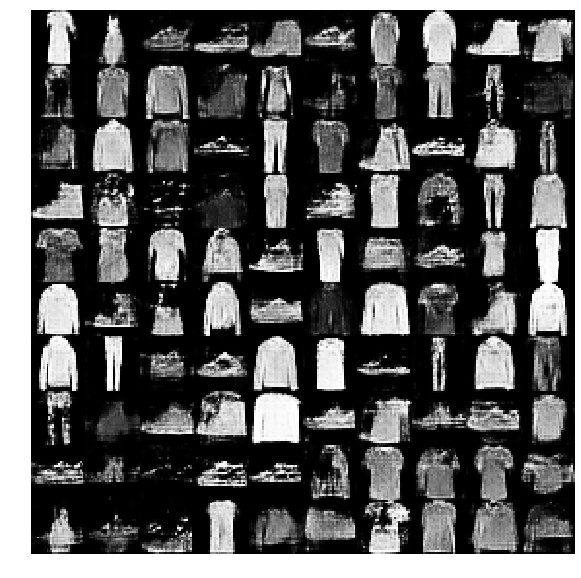

training step 6900: discriminator loss 1.2450510263442993; generator loss 0.7948862314224243
training step 7000: discriminator loss 0.9303625822067261; generator loss 0.7794967889785767


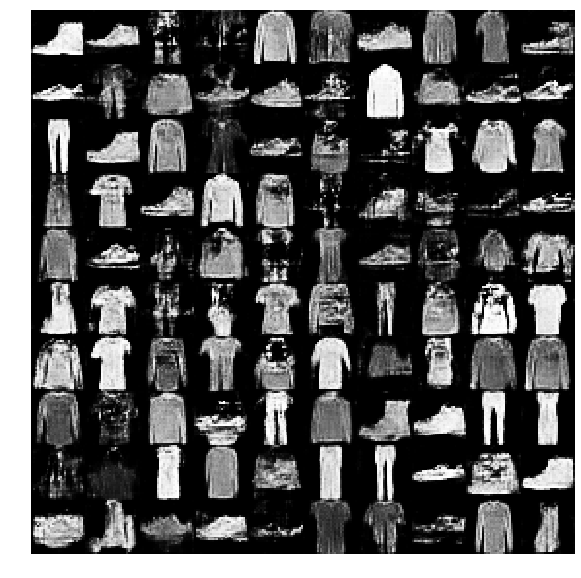

training step 7100: discriminator loss 0.9852652549743652; generator loss 0.5410070419311523
training step 7200: discriminator loss 0.9461963176727295; generator loss 0.44949501752853394


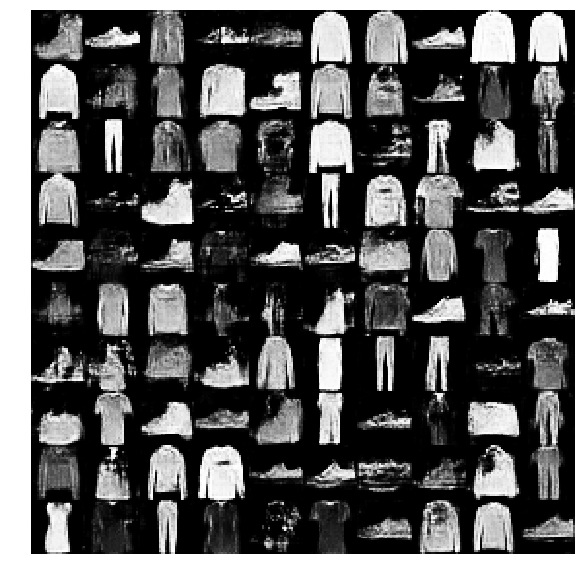

training step 7300: discriminator loss 1.1369960308074951; generator loss 0.9475631713867188
training step 7400: discriminator loss 1.3049781322479248; generator loss -0.09788060933351517


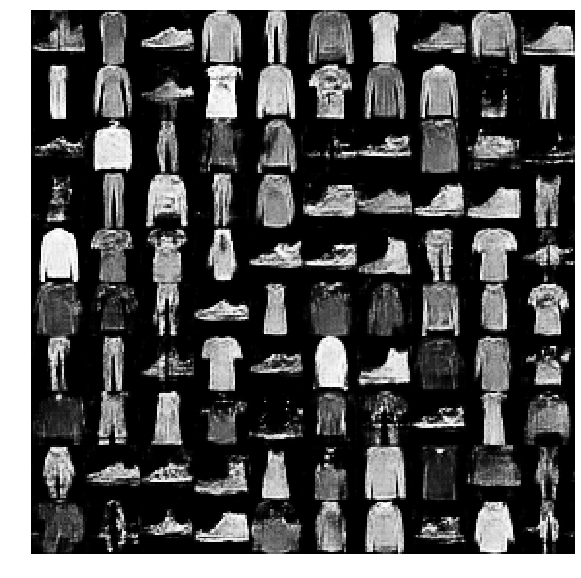

training step 7500: discriminator loss 1.1089714765548706; generator loss 0.8669946193695068
training step 7600: discriminator loss 1.0047444105148315; generator loss 0.3281680941581726


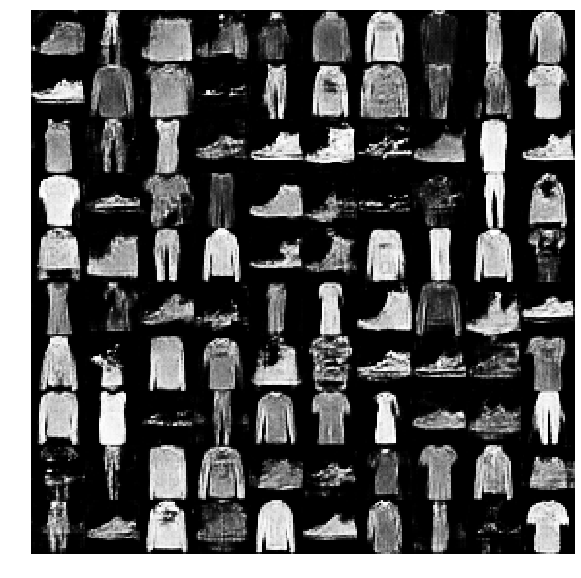

training step 7700: discriminator loss 1.114301323890686; generator loss 0.7748688459396362
training step 7800: discriminator loss 1.2651339769363403; generator loss 0.8940321207046509


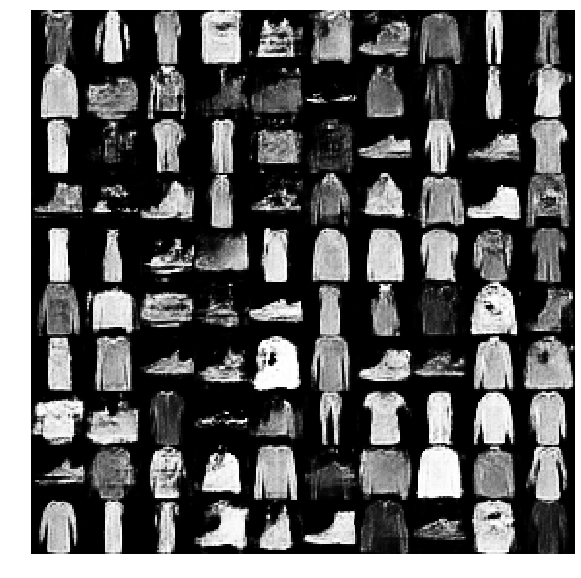

training step 7900: discriminator loss 1.0096116065979004; generator loss 0.35921794176101685
training step 8000: discriminator loss 1.0394874811172485; generator loss 0.7838201522827148


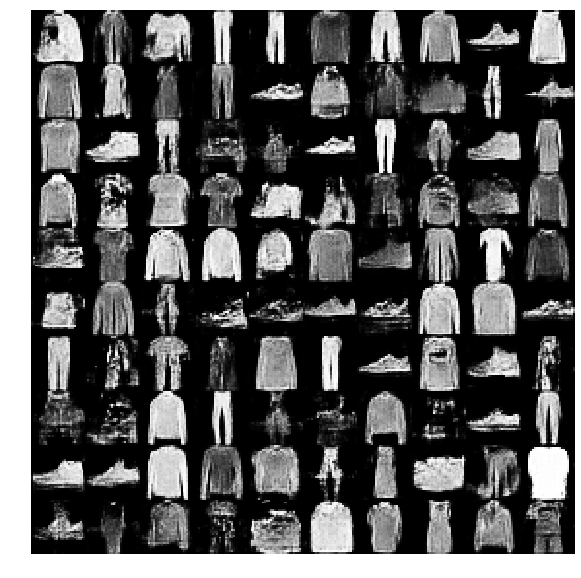

training step 8100: discriminator loss 0.9663088917732239; generator loss 0.8243149518966675
training step 8200: discriminator loss 1.0734223127365112; generator loss 0.20213404297828674


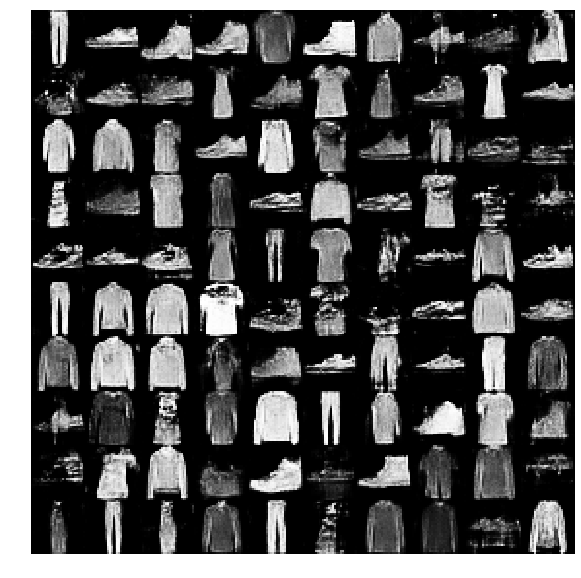

training step 8300: discriminator loss 1.056687355041504; generator loss 0.8764418363571167
training step 8400: discriminator loss 1.1177036762237549; generator loss 0.639809250831604


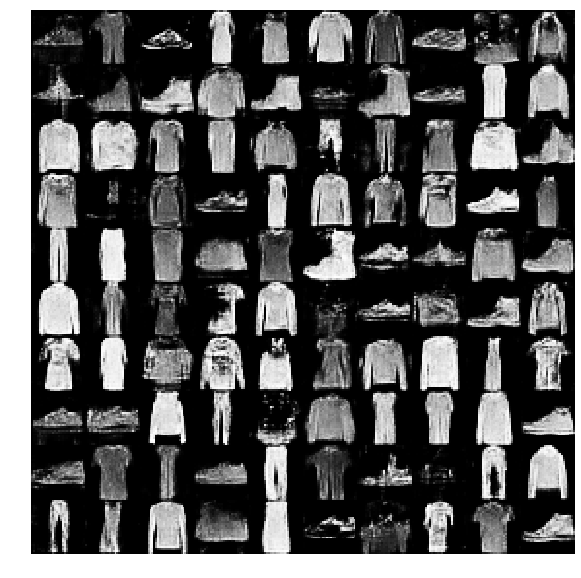

training step 8500: discriminator loss 1.2551242113113403; generator loss 0.7319552898406982
training step 8600: discriminator loss 0.9569151997566223; generator loss 0.4168563485145569


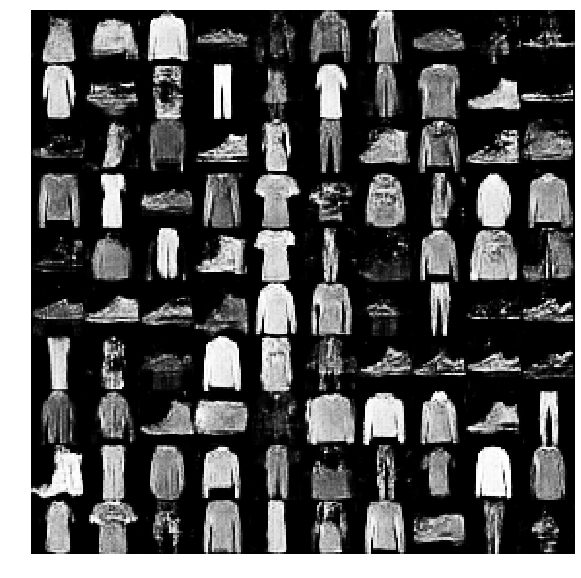

training step 8700: discriminator loss 1.1706721782684326; generator loss 0.8600672483444214
training step 8800: discriminator loss 0.9737135171890259; generator loss 0.36538395285606384


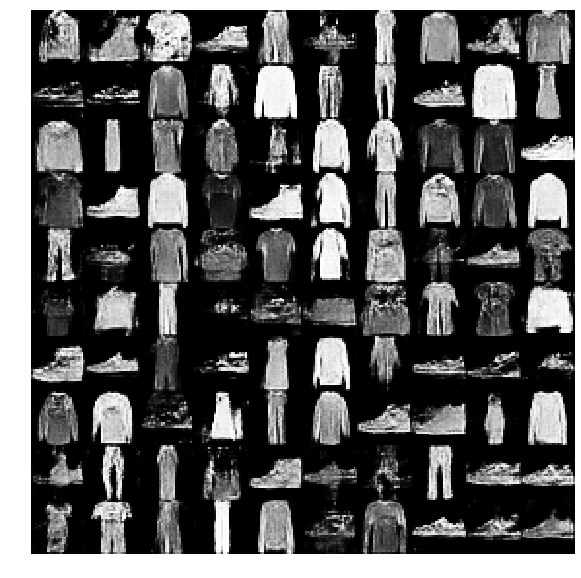

training step 8900: discriminator loss 1.2776182889938354; generator loss 0.8555837273597717
training step 9000: discriminator loss 1.2461823225021362; generator loss 0.7919789552688599


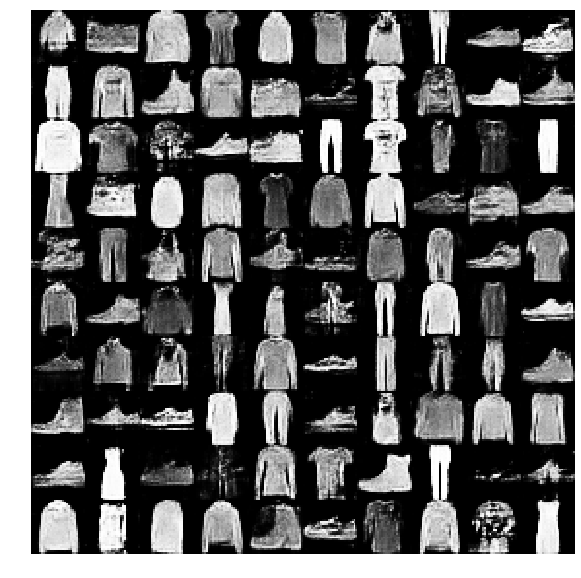

training step 9100: discriminator loss 1.2051193714141846; generator loss -0.011012017726898193
training step 9200: discriminator loss 0.9953066110610962; generator loss 0.3327016234397888


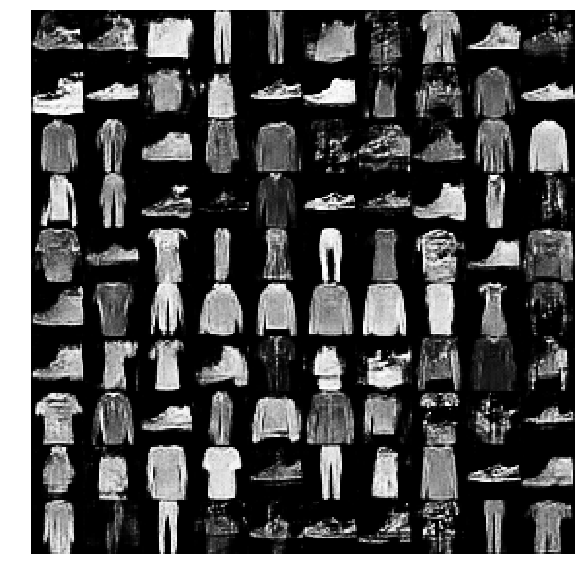

training step 9300: discriminator loss 0.9821984171867371; generator loss 0.1860348880290985
training step 9400: discriminator loss 1.0721244812011719; generator loss 0.5152963399887085


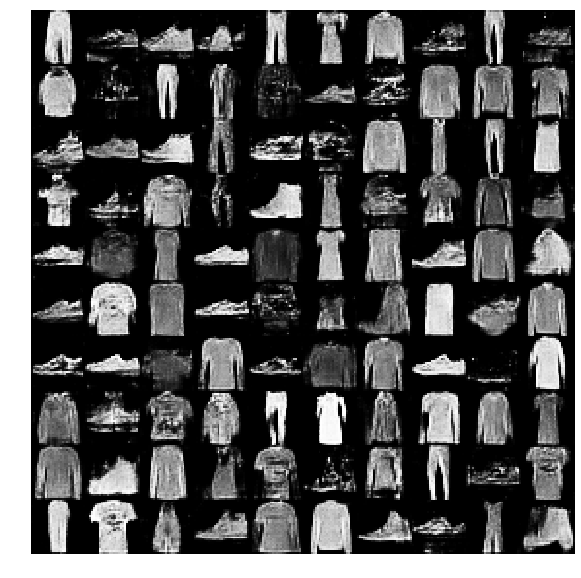

training step 9500: discriminator loss 1.1496412754058838; generator loss 0.8675866723060608
training step 9600: discriminator loss 1.082101821899414; generator loss 0.7922087907791138


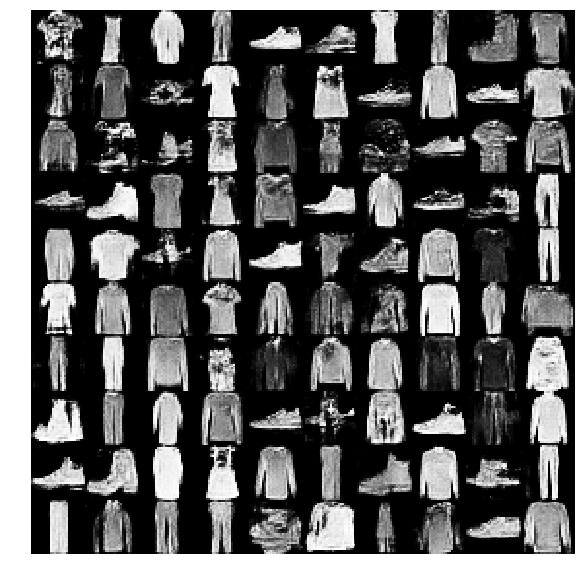

training step 9700: discriminator loss 1.0472996234893799; generator loss 0.801160454750061
training step 9800: discriminator loss 1.1216213703155518; generator loss 0.10433055460453033


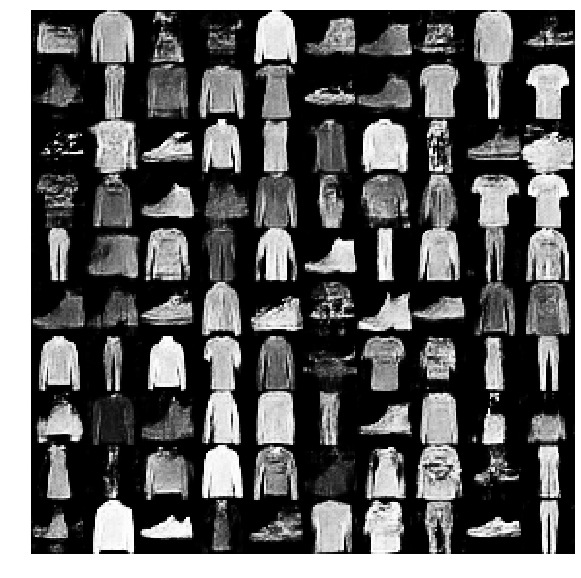

training step 9900: discriminator loss 0.8780556321144104; generator loss 0.7818301916122437
training step 10000: discriminator loss 1.2092516422271729; generator loss 0.9189359545707703


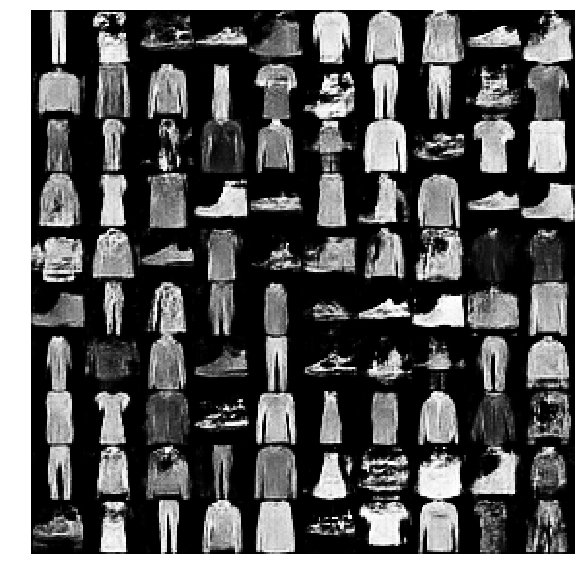

training step 10100: discriminator loss 1.2853673696517944; generator loss 0.9585305452346802
training step 10200: discriminator loss 0.9772719144821167; generator loss 0.16282528638839722


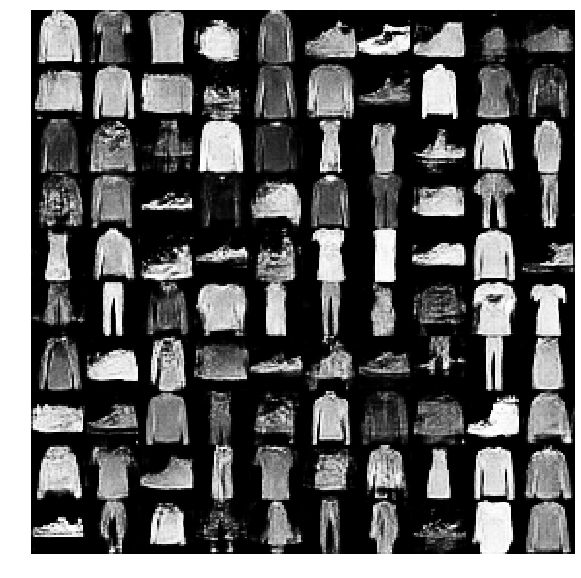

training step 10300: discriminator loss 1.002394437789917; generator loss 0.7062455415725708
training step 10400: discriminator loss 0.9124716520309448; generator loss 0.5991719365119934


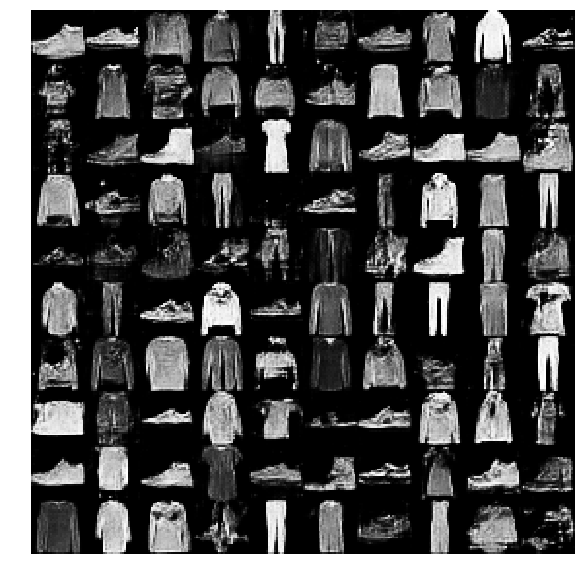

training step 10500: discriminator loss 0.9686809778213501; generator loss 0.2185942530632019
training step 10600: discriminator loss 1.2129127979278564; generator loss 0.9013200402259827


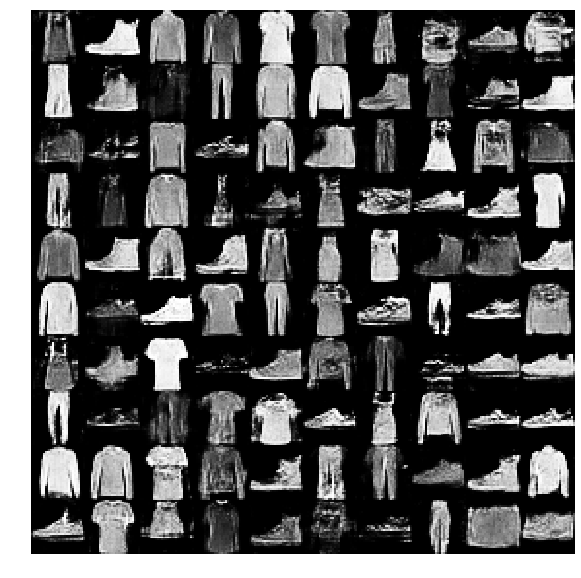

training step 10700: discriminator loss 0.9822161197662354; generator loss 0.6443279981613159
training step 10800: discriminator loss 1.0580756664276123; generator loss 0.19950450956821442


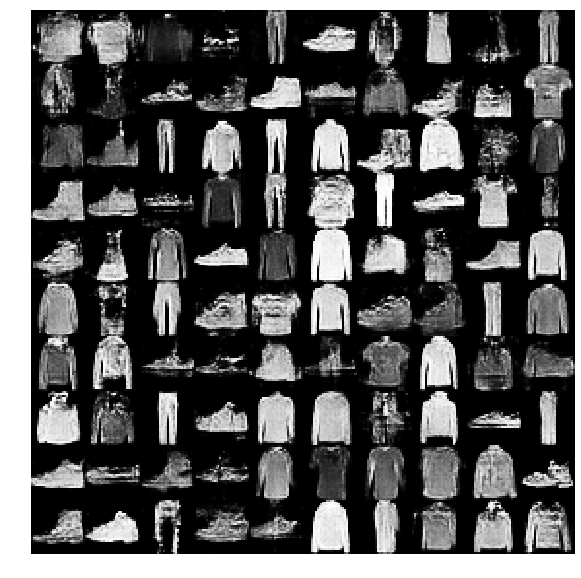

training step 10900: discriminator loss 1.084550380706787; generator loss 0.8948090076446533


In [17]:
# create global training step tracker object
global_step = tf.train.get_or_create_global_step()

# keep track of losses
d_losses, g_losses = [], []


for real_img_batch in dataset:

    # construct random normal z input to feed into generator
    input_z = tf.random_normal(shape=(BATCH_SIZE, LATENT_DIM), dtype='float32')

    # define gradient tapes to start recording computation operations
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
      

        # FORWARD RUN TO COMPUTE G/D-NET LOSSES
        # ----------------------------------------------------------------------
        # 1. run g_net with input_z to generate batch of fake images
        g_fake_images = g_net(input_z, training=True)  

        # 2. run d_net with the batch of generated fake images
        d_logits_fake = d_net(g_fake_images, training=True)
        
        # 3. run d_net with a batch of real images from dataset
        d_logits_real = d_net(real_img_batch, training=True)
        
        # 4. compute g_net losses with feedback from the d_net
        g_loss = compute_g_loss(d_logits_fake)
        g_losses.append(g_loss)
        
        # 5. compute d_net losses by revealing its logit values for both
        #    real and fake images
        d_loss = compute_d_loss(d_logits_real, d_logits_fake)
        d_losses.append(d_loss)
        
                          
        # UPDATE G/D-NET PARAMETERS
        # ----------------------------------------------------------------------
        # 1. get all learn-able G/D-net parameters (i.e. parameters to optimize)
        d_variables = d_net.variables
        g_variables = g_net.variables
                
        # 2. compute d(d_loss)/dx, d(g_loss)/dx
        d_grads = d_tape.gradient(d_loss, d_variables)
        g_grads = g_tape.gradient(g_loss, g_variables)

        # 3. apply gradient updates to the parameters
        d_optimizer.apply_gradients(zip(d_grads, d_variables),
                                    global_step=global_step)
        g_optimizer.apply_gradients(zip(g_grads, g_variables),
                                    global_step=global_step)

    
    # EVERY NOW & THEN, DISPLAY OUTPUT TO TRACK TRAINING PROGRESS
    # ----------------------------------------------------------------------
    # get training step
    step = global_step.numpy()
    
    # display losses every 100 steps
    if step % 100==0:
        print('training step {}: discriminator loss {}; generator loss {}'\
              .format(step, d_loss, g_loss))
    
    
    # display sample images every SAMPLE_PER_N_STEPS
    if step % SAMPLE_PER_N_STEPS==0:      
        
        # 1. create a batch of (100, LATENT_DIM) z-input tensor
        eval_z = tf.random_normal(shape=(100, LATENT_DIM), dtype='float32')

        # 2. generate images by using G-net
        eval_img = g_net(eval_z, training=False)
        
        # 3. organize the images into a grid
        img_grid = tf.contrib.gan.eval.image_grid(
                        input_tensor=eval_img,
                        grid_shape=(10,10),
                        image_shape=(H, W),
                        num_channels=C
                    )
                
        # 4. plot the image grid
        plt.figure(figsize=(10,10))
        plt.imshow(img_grid[0,:,:,0], cmap='gray')
        plt.axis('off')
        plt.show()